In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'accuracy = {accuracy}')
    recall = (tp) / (tp + fn)
    print(f'recall = {recall}')
    precision = (tp) / (tp + fp)
    print(f'precision = {precision}')
    print(f'tn:{tn} fp:{fp} fn:{fn} tp:{tp}')

In [14]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [15]:
import os
import glob
import pandas as pd

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
df2020 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv'
df2019 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv'

#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [16]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [17]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)    
    df = df[df[keyword] == True]
    return df

In [18]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    plt.savefig('../img/oped_news_hist.png')

In [19]:
printed_2020 = printed(df2020)
printed_2019 = printed(df2019)

In [20]:
print(printed_2020.shape)
print(printed_2019.shape)

(27752, 5)
(30232, 5)


# filter keywords

In [21]:
keyword_df2019 = filter_keyword(printed_2019)
keyword_df2020 = filter_keyword(printed_2020)

# concat

In [22]:
#concat df together
df = pd.concat([keyword_df2020])

In [23]:
%%time
df = df.copy()

CPU times: user 878 µs, sys: 480 µs, total: 1.36 ms
Wall time: 1.01 ms


In [24]:
df.shape

(4585, 6)

In [25]:
df.text.iloc[0]

'On the first Monday in May, the Department of Justice headquarters in Washington was on coronavirus lockdown — or at least it appeared to be from the outside. Signs posted on the outer doors facing Constitution Avenue admonished visitors to keep out if they had symptoms of Covid-19 or had been “exposed to any person diagnosed” with it. Inside, the guards operating the X-ray machines wore masks and gloves. Across the lobby, a free-standing pump of hand sanitizer cast a cautionary shadow down empty marble halls.But as you drew closer to the fifth floor, where Attorney General William Pelham Barr works out of a suite of offices, things started to loosen up. One assistant outside his conference room wore a mask, but the other did not. In the middle of the room, with its oil paintings and vaulted ceiling, the long central table had fewer chairs than you might expect, and an appropriate distance between them. But past the next door, inside the attorney general’s smaller personal office, Bar

In [26]:
last_check_before_split = (df.iloc[0])
last_check_before_split

keywords                                 [{'name': 'persons', 'value': 'Barr, William P...
pub_date                                                          2020-06-01T09:00:11+0000
type_of_material                                                                      News
print_page                                                                              20
text                                     On the first Monday in May, the Department of ...
United States Politics and Government                                                 True
Name: nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e, dtype: object

News: 3786 Oped: 799, Total: 4585, Op-Ed 0.17 of total


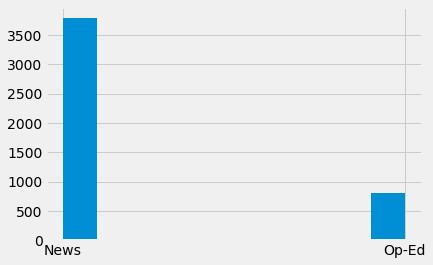

In [27]:
oped_v_news(df)

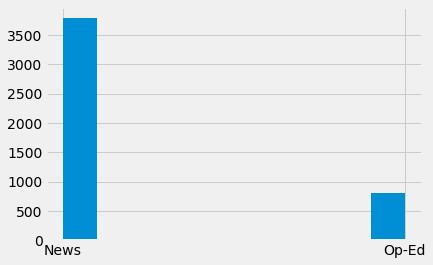

In [28]:
df.type_of_material.hist()

# X, y

In [29]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [30]:
#turn series into list...
corpus = list(X)

In [31]:
# define y as a series of op-ed or news
y = df.type_of_material

In [32]:
vectorize_y_ser(y)

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 4585, dtype: int64

In [33]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 1.9 ms, sys: 393 µs, total: 2.29 ms
Wall time: 1.93 ms


In [34]:
y.value_counts()

0    3786
1     799
Name: type_of_material, dtype: int64

In [35]:
y.shape

(4585,)

# remove stop words

# stemming/lemmatization

In [36]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [37]:
%%time
def snowball_tokenize(doc):
    snowball = SnowballStemmer('english')
    return [snowball.stem(word) for word in word_tokenize(doc.lower())]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [38]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


# vectorizer

# SNOWBALL tfidf

In [39]:
# %%time
# #create vectorizer

# snow_vectorizer = TfidfVectorizer(#input='content', 
# #                 encoding='utf-8', 
# #                 decode_error='strict', 
#                  strip_accents='ascii', 
#                  lowercase=True, 
# #                 preprocessor=None, 
#                  tokenizer=snowball_tokenize, 
# #                 analyzer='word', 
#                  stop_words='english', 
# #                 token_pattern='(?u)\b\w\w+\b', 
# #                 ngram_range=(1, 1), 
#                  max_df=0.90, 
#                  min_df=0.10, 
#                  max_features=None, 
# #                 vocabulary=None, 
# #                 binary=False, 
# #                 dtype=<class 'numpy.float64'>, 
# #                 norm='l2', 
# #                 use_idf=True, 
# #                 smooth_idf=True, 
# #                 sublinear_tf=False
# )

<!-- /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent)) -->

# WORDNET tfidf

In [40]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’':
            document = document.replace(char, " ")  
    return document

In [41]:
#stop_words = ['said','a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'mr','ms']


In [42]:
#stop_words = ['said']

In [43]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
                 analyzer='word', 
#                 stop_words=stop_words, 
#                 token_pattern='(?u)\b\w\w+\b', 
                 ngram_range=(1, 1), 
                 max_df=0.9, 
                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 43.2 µs


# test, train, split

In [44]:
#test, train, split 

In [45]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3438,) (1147,) (3438,) (1147,)
CPU times: user 3.67 ms, sys: 540 µs, total: 4.21 ms
Wall time: 3.91 ms


In [46]:
%%time
print(datetime.datetime.now())
X_train =  vectorizer.fit_transform(X_train)

2021-01-07 13:32:55.864116
CPU times: user 36.4 s, sys: 636 ms, total: 37.1 s
Wall time: 37.7 s


In [47]:
%%time
print(datetime.datetime.now())
X_test = vectorizer.transform(X_test)

2021-01-07 13:33:33.605480
CPU times: user 12 s, sys: 174 ms, total: 12.1 s
Wall time: 12.3 s


In [48]:
vocab = vectorizer.vocabulary_

In [49]:
len(vocab)

1107

In [50]:
X_train.shape

(3438, 1107)

In [51]:
X_test.shape

(1147, 1107)

# count vectorizer

In [52]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [53]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 615), (1, 615)]
RandomUnderSampler(random_state=0)
CPU times: user 6.43 ms, sys: 2.66 ms, total: 9.09 ms
Wall time: 8.3 ms


# random forest classifier

In [54]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)


2021-01-07 13:33:45.919203
CPU times: user 206 µs, sys: 74 µs, total: 280 µs
Wall time: 228 µs


In [55]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(1147,)

### metrics y_pred

In [56]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [57]:
print(y_test.shape)
print(y_pred.shape)

(1147,)
(1147,)


In [58]:
metrics_(tn, fp, fn, tp)

accuracy = 0.918918918918919
recall = 0.8913043478260869
precision = 0.6919831223628692
tn:890 fp:73 fn:20 tp:164


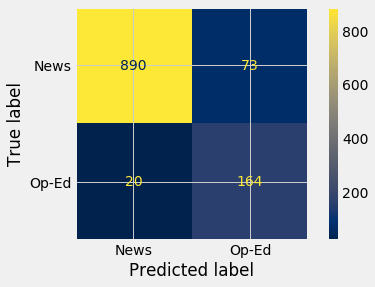

In [59]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                     cmap='cividis')

plt.savefig('../img/confusion_matrix.png');

# important features

### feature imporance

2021-01-07 13:33:46.655294
CPU times: user 463 ms, sys: 20.9 ms, total: 484 ms
Wall time: 492 ms


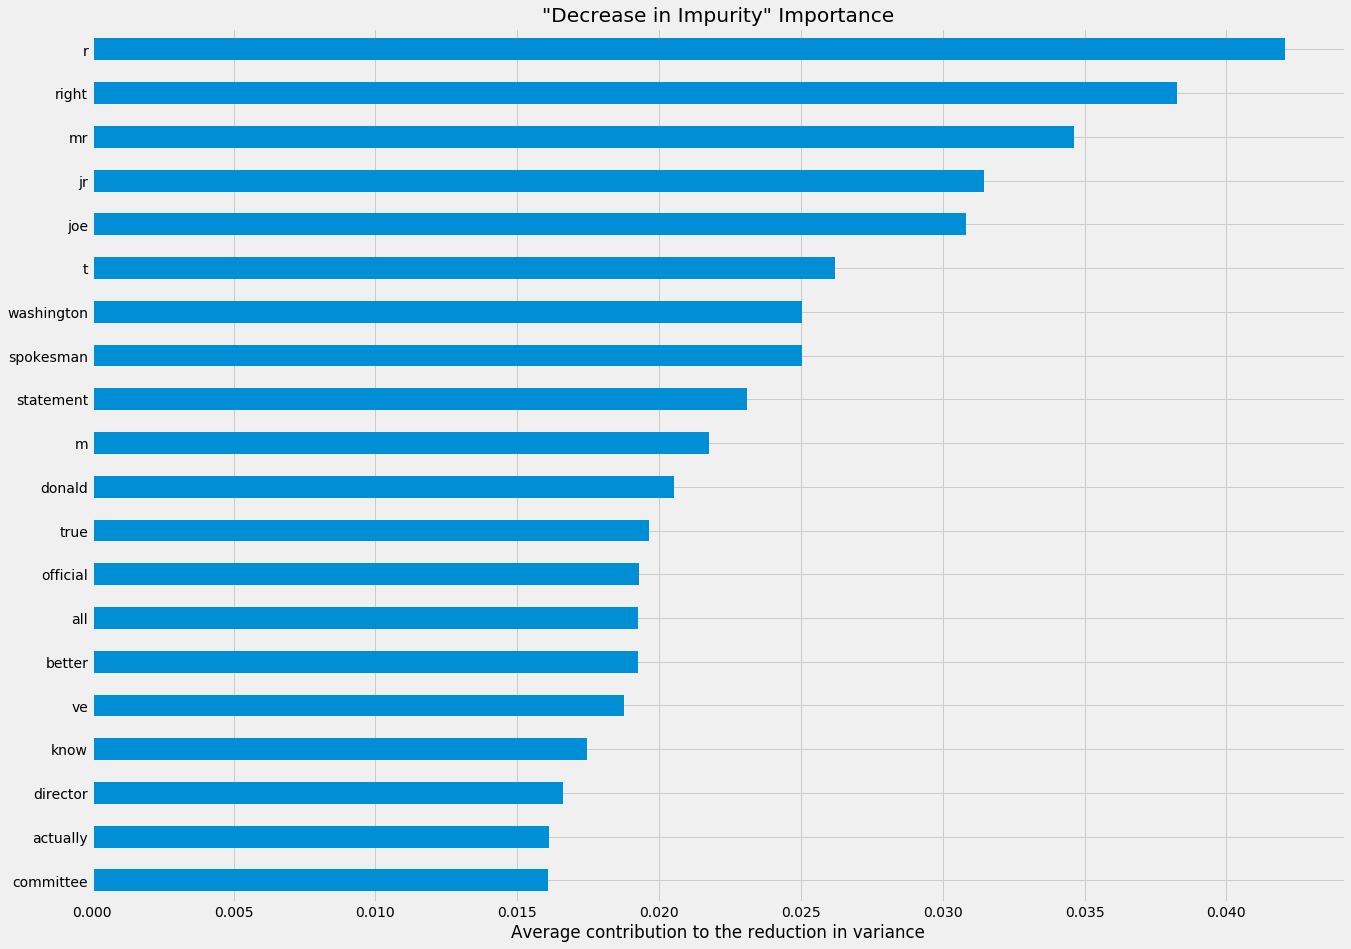

In [60]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import,
                           index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('../img/feature_imporance.png');

### permutation importance

In [61]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [62]:
len(feat_names)

1107

In [63]:
feat_names

['000',
 '1',
 '10',
 '100',
 '11',
 '12',
 '15',
 '19',
 '2',
 '20',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '25',
 '3',
 '30',
 '4',
 '40',
 '5',
 '50',
 '500',
 '6',
 '60',
 '7',
 '8',
 'ability',
 'able',
 'access',
 'according',
 'account',
 'accused',
 'acknowledged',
 'across',
 'act',
 'acting',
 'action',
 'activist',
 'activity',
 'actually',
 'added',
 'adding',
 'additional',
 'address',
 'administration',
 'adviser',
 'after',
 'again',
 'against',
 'agency',
 'agenda',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'aide',
 'air',
 'all',
 'allow',
 'allowed',
 'allowing',
 'ally',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'america',
 'american',
 'amid',
 'among',
 'amount',
 'announced',
 'another',
 'answer',
 'anti',
 'any',
 'anyone',
 'anything',
 'appeal',
 'appear',
 'appearance',
 'appeared',
 'appears',
 'approach',
 'approval',
 'approved',
 'april',
 'area',
 'argued',
 'argument',
 'around',
 'art

In [64]:
stop_words = vectorizer.stop_words_

In [65]:
len(stop_words)

42861

# save model as pickle file

In [66]:
filename = '/Users/djbetts/Desktop/full_dataset.pkl'

In [67]:
#pickle.dump(rf_clf, open(filename, 'wb'))

In [68]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [69]:
#loaded_model.fit(X_resampled, y_resampled)

In [70]:
#result = loaded_model.score(X_resampled, y_resampled)